# 1.线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 1.1 生成数据集
我们将根据带有噪声的线性模型构造一个数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。我们将使用低纬数据，这样可以很容易地将其可视化。</br>
我们将生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中抽样的两个特征。我们的合成数据是一个矩阵$X \in R^{1000 \times 2}$。</br>
我们使用线性模型参数$w=[2. -3.4]^T、b = 4.2$和噪声项$\epsilon $来生成数据集及其标签：
$$
y = Xw+b+\epsilon
$$
$\epsilon$ **可以视为模型预测和标签的潜在观测误差**。在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。为了，简化问题，我们将标准差设为0.01。</br>
**之所以生成数据时加上高斯噪声，是因为我们要模拟真实世界的观测误差，避免模型过拟合完美数据**。

In [3]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 参数的意义：均值，标准差，形状
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [4]:
true_w = torch.tensor([2, -3.4]) 
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# features中每一行都包含一个二维数据样本，labels每一行都包含一个标签值（标量值）。

In [6]:
print('feature:', features[0], '\nlabel:', labels[0])

feature: tensor([-1.0758,  0.7333]) 
label: tensor([-0.4502])


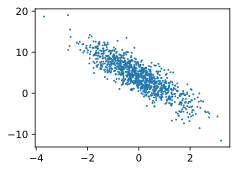

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

## 1.2 读取数据集
前面提到过，训练模型时要对数据集进行遍历，**每次抽取小批量样本**，并使用他们来更新我们的模型。由于这个过程是训练机器学习算法的基础，因此有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

In [11]:
def data_iter(batch_size, features, labels): # 接收批量大小、特征矩阵和标签向量
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 将indices的索引打乱

    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) # 每次取出打乱后 长度为batch_size的样本
        yield features[batch_indices], labels[batch_indices]

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
# 每个样本都可以被并行地进行计算，且每个样本损失函数的梯度也可以被并行计算

tensor([[-2.6389,  0.6146],
        [-0.5665,  1.5981],
        [ 0.1329,  2.2840],
        [ 0.2454, -1.1029],
        [ 0.3196,  0.7863],
        [ 0.5051,  0.5035],
        [-1.0548, -0.3931],
        [-0.6042, -0.9246],
        [-0.0541,  1.2926],
        [ 0.2549,  2.0118]]) 
 tensor([[-3.1638],
        [-2.3655],
        [-3.3063],
        [ 8.4360],
        [ 2.1756],
        [ 3.4806],
        [ 3.4247],
        [ 6.1222],
        [-0.3105],
        [-2.1152]])


**在深度学习框架中实现的内置迭代器的效率要高的多，它可以处理存储在文件中的数据和数据流提供的数据。**

## 1.3 初始化模型参数
在开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。**通过均值为0、标准差为0.01的正态分布中抽样随机数来初始化权重，并将偏执初始化0。**

In [15]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足以拟合我们的数据。每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。

## 1.4 定义模型

In [16]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b # 会利用广播机制进行相加。

## 1.5 定义损失函数

In [17]:
def squqred_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 1.6 定义优化算法（小批量随机梯度下降）
在每一步，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。

In [20]:
def sgd(params, lr, batch_size): #@save 
    """小批量随机梯度下降"""
    with torch.no_grad(): 
        """
        禁用梯度跟踪，确保参数更新操作不会记录到计算图中， 就是让:
        param -= lr * param.grad / batch_size
        param.grad.zero_()
        这两步不参与梯度更新
        """
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 将梯度清零，不然默认会累加